In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import *
import torch,torchvision
from tqdm import tqdm
device = 'cuda'
PROJECT_NAME = 'Intel-Image-Clf'

In [2]:
def load_data():
    X = []
    y = []
    labels = {}
    idx = -1
    for folder in tqdm(os.listdir('./data/')):
        idx += 1
        labels[folder] = idx
        for file in os.listdir(f'./data/{folder}/'):
            file = f'./data/{folder}/{file}'
            img = cv2.imread(file)
            img = cv2.resize(img,(112,112))
            X.append(img/255.0)
            y.append(labels[folder])
    return X,y,idx,labels

In [3]:
X,y,idx,labels = load_data()

100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


In [4]:
idx

5

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,test_size=0.125)

In [7]:
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(np.array(y_train))
y_test = torch.from_numpy(np.array(y_test))

In [8]:
def get_loss(preds,y,criterion):
    loss = criterion(preds,y)
    return loss.item()
def get_accuracy(preds,y):
    total = -1
    correct = -1
    for pred,y_batch in zip(preds,y):
        pred = torch.argmax(pred)
        pred = round(float(pred))
        y_batch = round(float(y_batch))
        if pred == y_batch:
            correct += 1
        total += 1
    return round(total/correct,3)

In [9]:
def pred_test_data(model):
    preds = []
    for file in os.listdir('./test_data/'):
        file = f'./test_data/{file}'    
        img = cv2.imread(file)
        img = cv2.resize(img,(112,112))
        pred = model(torch.from_numpy(img).to(device).float().view(-1,3,112,112))
        plt.figure(figsize=(12,7))
        plt.imshow(img)
        plt.title(f'{labels[int(torch.argmax(pred))]}')
        plt.savefig(f'./preds/{file}')
        plt.close()
        preds.append(torch.argmax(pred))
    return preds

In [10]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.activation = ReLU()
        self.conv1 = Conv2d(3,8,(3,3))
        self.conv1batchnorm = BatchNorm2d(8)
        self.conv2 = Conv2d(8,12,(3,3))
        self.conv2batchnorm = BatchNorm2d(12)
        self.conv3 = Conv2d(12,16,(5,5))
        self.conv3batchnorm = BatchNorm2d(16)
        self.conv4 = Conv2d(16,20,(5,5))
        self.conv4batchnorm = BatchNorm2d(20)
        self.linear1 = Linear(20*3*3,32)
        self.linear1batchnorm = BatchNorm1d(32)
        self.linear2 = Linear(32,64)
        self.linear2batchnorm = BatchNorm1d(64)
        self.linear3 = Linear(64,128)
        self.linear3batchnorm = BatchNorm1d(128)
        self.linear4 = Linear(128,256)
        self.linear4batchnorm = BatchNorm1d(256)
        self.linear5 = Linear(256,128)
        self.linear5batchnorm = BatchNorm1d(128)
        self.output = Linear(128,6)
        
    def forward(self,X):
        preds = X
        preds = self.max_pool2d(self.activation(self.conv1batchnorm(self.conv1(preds))))
        preds = self.max_pool2d(self.activation(self.conv2batchnorm(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3batchnorm(self.conv3(preds))))
        preds = self.max_pool2d(self.activation(self.conv4batchnorm(self.conv4(preds))))
        preds = preds.view(-1,20*3*3)
        preds = self.activation(self.linear1batchnorm(self.linear1(preds)))
        preds = self.activation(self.linear2batchnorm(self.linear2(preds)))
        preds = self.activation(self.linear3batchnorm(self.linear3(preds)))
        preds = self.activation(self.linear4batchnorm(self.linear4(preds)))
        preds = self.activation(self.linear5batchnorm(self.linear5(preds)))
        preds = self.output(preds)
        return preds

In [11]:
model = Model()

In [12]:
model.to(device)

Model(
  (max_pool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv1batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2batchnorm): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv4batchnorm): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=180, out_features=32, bias=True)
  (linear1batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=32, out_features=64, bias=True

In [13]:
criterion = CrossEntropyLoss()

In [14]:
from torch.optim import *

In [15]:
optimizer = Adam(model.parameters(),lr=0.001)

In [16]:
epochs = 100

In [17]:
batch_size=  32

In [18]:
import wandb

In [19]:
labels

{'glacier': 0,
 'street': 1,
 'forest': 2,
 'sea': 3,
 'buildings': 4,
 'mountain': 5}

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/100 [00:00<?, ?it/s]

4
tensor([[-0.1450, -0.0112, -0.2375,  0.5465, -0.0659, -0.3908],
        [ 0.5943, -0.3997, -0.3158,  0.6821, -0.8885, -0.3569],
        [ 0.7664,  0.5571, -0.0924,  0.1124,  0.1240,  0.3100],
        [ 0.1928,  0.3665, -0.2244,  0.1439, -0.2502, -0.2039]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor(12, device='cuda:0')


KeyError: 12

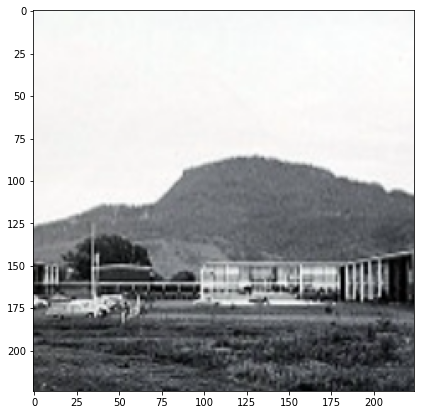

In [20]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
        X_batch = X_train[i:i+batch_size].to(device).float().view(-1,3,112,112)
        y_batch = y_train[i:i+batch_size].to(device)
        preds = model(X_batch)
        preds = preds.to(device)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({'Loss':loss.item()})
        wandb.log({'Val Loss':get_loss(model(X_test.to(device).float().view(-1,3,112,112)),y_test.to(device),criterion)})
        wandb.log({'Accuracy':get_accuracy(preds,y_batch)})
        wandb.log({'Val Accuracy':get_accuracy(model(X_test.to(device).float().view(-1,3,112,112)),y_test.to(device))})
        pred_test_data(model)
        for file in os.listdir('./preds/'):
            wandb.log({f'/Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
        wandb.watch(model)
wandb.watch(model)
wandb.finish()

In [21]:
t = torch.tensor([[-0.1450, -0.0112, -0.2375,  0.5465, -0.0659, -0.3908],
        [ 0.5943, -0.3997, -0.3158,  0.6821, -0.8885, -0.3569],
        [ 0.7664,  0.5571, -0.0924,  0.1124,  0.1240,  0.3100],
        [ 0.1928,  0.3665, -0.2244,  0.1439, -0.2502, -0.2039]],
       device='cuda:0')

In [24]:
torch.argmax(torch.squeeze(t))

tensor(12, device='cuda:0')

In [ ]:
torch.argmax(preds[2])

In [ ]:
idx

In [ ]:
batch_size

In [ ]:
X_batch.shape

In [ ]:
len(X_train)

In [ ]:
len(y_train)

In [ ]:
y_batch.shape

In [ ]:
preds.shape